In [2]:
!nvidia-smi

Wed Mar 23 07:49:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0  On |                  N/A |
|  0%   33C    P3    33W / 175W |    941MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

#Fix for same result
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2) 

print('Libraries Loaded')

Libraries Loaded


# Utilities

In [4]:
def read_file(path):
    '''
    Returns the dataframe which is read from the excel file present in the path specified. 
    
    Parameters:
        path (str) : The path of the file
    
    Returns:
        df (float) : The dataframe which is created after reading the file.
    '''
    df= pd.read_csv(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    '''
    Returns the prepared data based on the lag and look ahead
    
    Parameters:
        X          (float): The independent variables of the data
        y          (float): The dependent variables of the data
        time_steps (int)  : The lag that is being used to lookback
        ts_range   (int)  : The lookahead for the data
    
    Returns:
        Xs (float) : The numpy array of the input variable
        ys (float) : The numpy array of the output variable 
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    '''
    Returns the training and testing data
    
    Parameters:
        df (float): The whole dataframe containing the independent and dependent variables
        output(str): The output variable 
        lag (int): The lag that needs to be applied for the data
        duration (int): The duration that is being considered as output
        ts (float): The percentage of training data
    
    Returns:
        x_train (float): The training data of independent variable 
        x_test (float): The testing data of independent variable
        y_train (float): The training data of the depenedent variable 
        y_test (float): The testing data of the dependent variable 
    '''
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    Attention layer for the neural networks.
    
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being inspired from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

# Load cleaned data

In [5]:
df_up = pd.read_pickle('upstream.pkl')
df_down = pd.read_pickle('downstream.pkl')
df_up.head()

,Air_Temp_Up,Water_Temp_Up,Chloride_Up,pH_Up,Cond_Up,Turbidity_Up,DO_Up,DO_Up
0,20.2150,10.6650,97.0900,8.500,740.0,3.500,11.3000,11.3000
1,20.5575,11.4225,95.8975,8.500,730.0,2.900,11.4525,11.4525
2,23.3150,12.3825,93.8325,8.500,725.0,3.100,11.5250,11.5250
3,23.3275,13.3350,93.6525,8.575,720.0,3.500,11.4000,11.4000
4,24.3900,14.0200,93.8050,8.600,720.0,3.425,11.2200,11.2200


In [9]:
df_down.head()

,Air_Temp_Dn,Water_Temp_Dn,Chloride_Dn,pH_Dn,Cond_Dn,Turbidity_Dn,DO_Dn
0,13.3700,11.8050,111.950,8.300,840.0,2.250,11.7350
1,15.1125,12.6925,113.500,8.375,840.0,1.500,11.7275
2,15.2275,13.8375,116.525,8.400,840.0,1.650,11.4825
3,17.7450,14.6900,118.175,8.400,840.0,1.225,11.1100
4,19.3625,15.7975,120.775,8.400,840.0,1.150,10.9625


In [6]:

# Change the lag,duration variable values according to experiment value taken
# EPOCHS = 5 (taken for demonstration of code working, later we can change it 200 or higher epochs)

lag = 6
duration = 6
EPOCHS = 30
BATCH_SIZE = 32
LR = 1E-3

train_size = 0.8


In [7]:
target_column = ['DO_Dn']

## Creating the training and testing data
x_train,x_test,y_train,y_test,scaler = splitter(df_down,target_column,lag,duration,train_size)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(31876, 7) (7969, 7)
The shape of x_train is (31864, 6, 7) and x_test is (7957, 6, 7)
The shape of y_train is (31864, 6) and y_test is (7957, 6)


# Models

In [8]:
from pathlib import Path

working_dir = Path('results_only_down')
working_dir.mkdir(exist_ok=True)

## LSTM Model

In [21]:
## Creating the prelimaries 

filepath_simple = working_dir / Path('simple_lstm.hdf5')
filepath_attention = working_dir / Path('attention_lstm.hdf5')

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [22]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
# Problem downgrade numpy==1.19.5 for next command
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 11s 9ms/step - loss: 0.0113 - mae: 0.0740 - val_loss: 0.0064 - val_mae: 0.0667
Epoch 2/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0045 - mae: 0.0516 - val_loss: 0.0044 - val_mae: 0.0513
Epoch 3/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0035 - mae: 0.0447 - val_loss: 0.0033 - val_mae: 0.0441
Epoch 4/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0027 - mae: 0.0393 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 5/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0025 - val_mae: 0.0369
Epoch 6/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0023 - mae: 0.0358 - val_loss: 0.0020 - val_mae: 0.0306
Epoch 7/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0022 - mae: 0.0347 - val_loss: 0.0018 - val_mae: 0.0314
Epoch 8/30
897/897 [==============================] - 7s 8ms/step - loss: 0

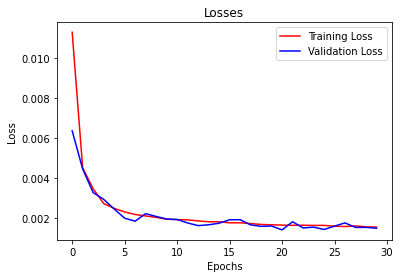

The Mean Squared Error is: 0.525206119767404


In [23]:
## Saving the result file to the folder of the model
history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [24]:
## Attention model
K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 12s 9ms/step - loss: 0.0125 - mae: 0.0765 - val_loss: 0.0062 - val_mae: 0.0631
Epoch 2/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0047 - mae: 0.0531 - val_loss: 0.0053 - val_mae: 0.0599
Epoch 3/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 0.0043 - val_mae: 0.0507
Epoch 4/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0036 - mae: 0.0461 - val_loss: 0.0043 - val_mae: 0.0520
Epoch 5/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0033 - mae: 0.0436 - val_loss: 0.0038 - val_mae: 0.0478
Epoch 6/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0029 - mae: 0.0408 - val_loss: 0.0030 - val_mae: 0.0424
Epoch 7/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0026 - mae: 0.0384 - val_loss: 0.0024 - val_mae: 0.0352
Epoch 8/30
897/897 [==============================] - 8s 9ms/step - loss: 0

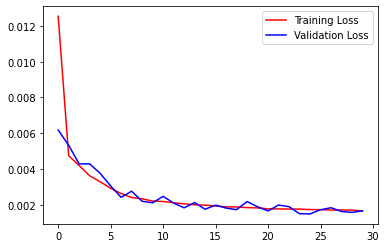

The Mean Squared Error is: 0.45760697291457963


In [25]:
history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))   

wk.save(working_dir / Path('LSTM Result.xls'))

## CNN-LSTM

In [26]:
## Creating the prelimaries 

filepath_simple = working_dir / Path('simple_cnnlstm.hdf5')
filepath_attention = working_dir / Path('attention_cnnlstm.hdf5')

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [27]:
## Simple CNN-LSTM model
K.clear_session()
simple_cnnlstm = keras.Sequential()
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.Flatten())
simple_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(32))
simple_cnnlstm.add(keras.layers.Dense(6))

simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 9s 6ms/step - loss: 0.0060 - mae: 0.0478 - val_loss: 0.0031 - val_mae: 0.0412
Epoch 2/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0029 - val_mae: 0.0368
Epoch 3/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0317
Epoch 4/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 5/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0019 - val_mae: 0.0327
Epoch 6/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0021 - val_mae: 0.0331
Epoch 7/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 8/30
897/897 [==============================] - 5s 5ms/step - loss: 0.

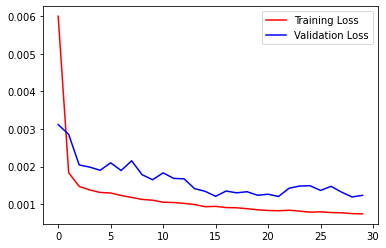

The Mean Squared Error is: 0.46427766819806293


In [28]:
history = simple_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_cnnlstm.load_weights(filepath_simple)
preds = simple_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [29]:
## Attention model
K.clear_session()
atten_cnnlstm = keras.Sequential()
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(attention(return_sequences=True))
atten_cnnlstm.add(keras.layers.Flatten())
atten_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(32))
atten_cnnlstm.add(keras.layers.Dense(6))

atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 8s 6ms/step - loss: 0.0073 - mae: 0.0517 - val_loss: 0.0035 - val_mae: 0.0434
Epoch 2/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 0.0030 - val_mae: 0.0362
Epoch 3/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0020 - val_mae: 0.0308
Epoch 4/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0021 - val_mae: 0.0331
Epoch 5/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0018 - val_mae: 0.0313
Epoch 6/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0020 - val_mae: 0.0322
Epoch 7/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 0.0019 - val_mae: 0.0316
Epoch 8/30
897/897 [==============================] - 5s 6ms/step - loss: 0.

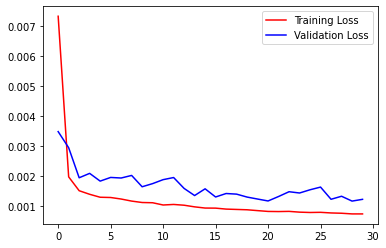

The Mean Squared Error is: 0.481596069473155


In [30]:
history = atten_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_cnnlstm.load_weights(filepath_attention)
preds = atten_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)


e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

        sheet3.write(0,i,"Real-test")
        sheet4.write(0,i,"Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                sheet3.write(j+1,i,float(y_test_unscaled[j,i]))
        for k in range(y_pred_unscaled.shape[0]):
                sheet4.write(k+1,i,float(y_pred_unscaled[k,i]))
            
wk.save(working_dir / Path('CNN-LSTM Results.xls'))


## ConvLSTM Model

In [9]:
## Creating the prelimaries 

filepath_simple = working_dir / Path('simple_convlstm.hdf5')
filepath_attention = working_dir / Path('attention_convlstm.hdf5')

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)


In [10]:
## Reshaping the training and testing data to suit the convlstm model
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [11]:
## Simple ConvLSTM model
K.clear_session()
simple_convlstm = keras.Sequential()
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.Flatten())
simple_convlstm.add(keras.layers.Dense(512, activation='relu'))
simple_convlstm.add(keras.layers.Dense(128, activation='relu'))
simple_convlstm.add(keras.layers.Dense(64, activation='relu'))
simple_convlstm.add(keras.layers.Dense(32))
simple_convlstm.add(keras.layers.Dense(6))

simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 39s 32ms/step - loss: 0.0092 - mae: 0.0594 - val_loss: 0.0058 - val_mae: 0.0596
Epoch 2/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0024 - mae: 0.0359 - val_loss: 0.0032 - val_mae: 0.0409
Epoch 3/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0017 - mae: 0.0294 - val_loss: 0.0023 - val_mae: 0.0346
Epoch 4/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0016 - mae: 0.0277 - val_loss: 0.0021 - val_mae: 0.0321
Epoch 5/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0023 - val_mae: 0.0354
Epoch 6/30
897/897 [==============================] - 29s 32ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0018 - val_mae: 0.0305
Epoch 7/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0019 - val_mae: 0.0307
Epoch 8/30
897/897 [==============================] - 26s 29ms

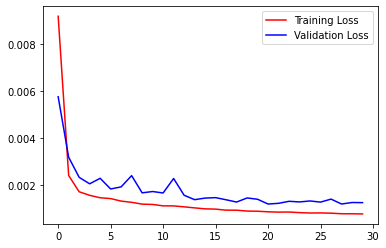

The Mean Squared Error is: 0.411879780001527


In [12]:
history = simple_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_convlstm.load_weights(filepath_simple)
preds = simple_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [13]:
## Attention model
K.clear_session()
atten_convlstm = keras.Sequential()
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(attention(return_sequences=True))
atten_convlstm.add(keras.layers.Flatten())
atten_convlstm.add(keras.layers.Dense(512, activation='relu'))
atten_convlstm.add(keras.layers.Dense(128, activation='relu'))
atten_convlstm.add(keras.layers.Dense(64, activation='relu'))
atten_convlstm.add(keras.layers.Dense(32))
atten_convlstm.add(keras.layers.Dense(6))

atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Epoch 1/30
897/897 [==============================] - 34s 32ms/step - loss: 0.0090 - mae: 0.0594 - val_loss: 0.0051 - val_mae: 0.0577
Epoch 2/30
897/897 [==============================] - 28s 31ms/step - loss: 0.0022 - mae: 0.0339 - val_loss: 0.0026 - val_mae: 0.0356
Epoch 3/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0016 - mae: 0.0283 - val_loss: 0.0022 - val_mae: 0.0333
Epoch 4/30
897/897 [==============================] - 27s 31ms/step - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0019 - val_mae: 0.0298
Epoch 5/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0021 - val_mae: 0.0332
Epoch 6/30
897/897 [==============================] - 27s 30ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0021 - val_mae: 0.0334
Epoch 7/30
897/897 [==============================] - 28s 31ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0020 - val_mae: 0.0311
Epoch 8/30
897/897 [==============================] - 27s 30ms

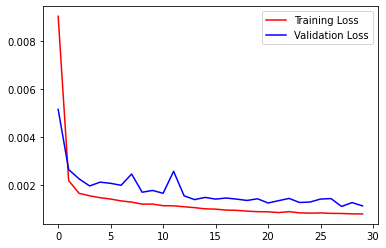

The Mean Squared Error is: 0.43192794005030427


In [14]:
history = atten_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_convlstm.load_weights(filepath_attention)
preds = atten_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))

wk.save(working_dir / Path('ConvLSTM Results.xls'))

## Seq2Seq Model

In [15]:
## Creating the prelimaries 

filepath_simple = working_dir / Path('simple_seq2seq.hdf5')
filepath_attention = working_dir / Path('attention_seq2seq.hdf5')

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [16]:
## Reshaping the training data to suit Seq2Seq model
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [17]:
## Simple Model
K.clear_session()
input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

### --------------------------------Encoder Section -----------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=False, return_state=True)(encoder_third)

###---------------------------------Decorder Section-----------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
decoder_third = keras.layers.LSTM(128,return_sequences=True)(decoder_second)
decoder_fourth = keras.layers.LSTM(128,return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128,return_sequences=True)(decoder_fourth)
print(decoder_fifth)

###--------------------------------Output Section-------------------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

simple_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=LR)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 128), dtype=tf.float32, name=None), name='lstm_7/PartitionedCall:1', description="created by layer 'lstm_7'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       69632       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (N

Epoch 1/30
897/897 [==============================] - 21s 16ms/step - loss: 0.0102 - mae: 0.0636 - val_loss: 0.0060 - val_mae: 0.0605
Epoch 2/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0037 - mae: 0.0459 - val_loss: 0.0043 - val_mae: 0.0515
Epoch 3/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0025 - mae: 0.0372 - val_loss: 0.0025 - val_mae: 0.0365
Epoch 4/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0016 - mae: 0.0284 - val_loss: 0.0021 - val_mae: 0.0336
Epoch 5/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 6/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0017 - val_mae: 0.0295
Epoch 7/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0012 - mae: 0.0239 - val_loss: 0.0016 - val_mae: 0.0273
Epoch 8/30
897/897 [==============================] - 13s 14ms

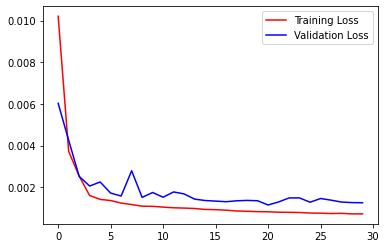

(7957, 6)
The Mean Squared Error is: 0.46220399250705607


In [18]:
history = simple_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_seq.load_weights(filepath_simple)
preds = simple_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [19]:
## Attention Model
K.clear_session()

input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

###----------------------------------------Encoder Section------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=True,return_state=True)(encoder_third)

###-----------------------------------------Decoder Section------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth_s1)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first, initial_state=[encoder_fourth_s1, encoder_fourth_s2])

attention = keras.layers.dot([decoder_second, encoder_fourth], axes=[2, 2])
attention = keras.layers.Activation('softmax')(attention)
context = keras.layers.dot([attention, encoder_fourth], axes=[2, 1])

decoder_third = keras.layers.concatenate([context, decoder_second])

decoder_fourth = keras.layers.LSTM(128, return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128, return_sequences=True)(decoder_fourth)
decoder_sixth = keras.layers.LSTM(128, return_sequences=True)(decoder_fifth)

###-----------------------------------------Output Section-----------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_sixth)

atten_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=LR)
atten_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
atten_seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       69632       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
______________________________________________________________________________________________

Epoch 1/30
897/897 [==============================] - 21s 17ms/step - loss: 0.0111 - mae: 0.0664 - val_loss: 0.0061 - val_mae: 0.0606
Epoch 2/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0038 - mae: 0.0466 - val_loss: 0.0045 - val_mae: 0.0514
Epoch 3/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0025 - mae: 0.0370 - val_loss: 0.0026 - val_mae: 0.0370
Epoch 4/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0016 - mae: 0.0284 - val_loss: 0.0023 - val_mae: 0.0382
Epoch 5/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 6/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0013 - mae: 0.0254 - val_loss: 0.0017 - val_mae: 0.0279
Epoch 7/30
897/897 [==============================] - 13s 14ms/step - loss: 0.0012 - mae: 0.0240 - val_loss: 0.0015 - val_mae: 0.0281
Epoch 8/30
897/897 [==============================] - 13s 15ms

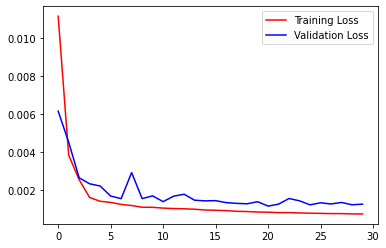

(7957, 6)
The Mean Squared Error is: 0.43432155413908197


In [20]:
history = atten_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_seq.load_weights(filepath_attention)
preds = atten_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))

wk.save(working_dir / Path('Seq2Seq Results.xls'))

## Wavenet Model

In [21]:
## Creating the prelimaries 

filepath_simple = working_dir / Path('simple_wavenet.hdf5')
filepath_attention = working_dir / Path('attention_wavenet.hdf5')

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [22]:
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = keras.layers.Conv1D(64, 1, padding='same')(x) 
    x_f = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = keras.layers.Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(z)

    x = keras.layers.Add()([x, z])    

    skips.append(z)

out = keras.layers.Activation('relu')(keras.layers.Add()(skips)) 
out = keras.layers.Conv1D(128, 1, padding='same')(out)
out = keras.layers.Activation('relu')(out)
out = keras.layers.Dropout(0.4)(out)
out = keras.layers.Conv1D(1, 1, padding='same')(out)

out = keras.layers.Flatten()(out)
out = keras.layers.Dense(6)(out)

simple_wavenet = keras.Model(inputs, out)

simple_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])


Epoch 1/30
897/897 [==============================] - 19s 18ms/step - loss: 0.0122 - mae: 0.0740 - val_loss: 0.0041 - val_mae: 0.0524
Epoch 2/30
  7/897 [..............................] - ETA: 15s - loss: 0.0041 - mae: 0.0485

C:\Users\WSF_CA_2021\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


897/897 [==============================] - 15s 17ms/step - loss: 0.0036 - mae: 0.0458 - val_loss: 0.0027 - val_mae: 0.0364
Epoch 3/30
897/897 [==============================] - 15s 16ms/step - loss: 0.0025 - mae: 0.0378 - val_loss: 0.0026 - val_mae: 0.0367
Epoch 4/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0020 - mae: 0.0334 - val_loss: 0.0027 - val_mae: 0.0388
Epoch 5/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0021 - val_mae: 0.0315
Epoch 6/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0020 - val_mae: 0.0325
Epoch 7/30
897/897 [==============================] - 17s 19ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0018 - val_mae: 0.0300
Epoch 8/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0014 - mae: 0.0270 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 9/30
897/897 [==============================] - 16s 18ms/step - los

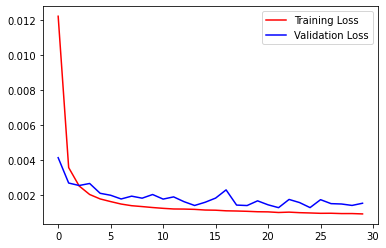

(7957, 6)
The Mean Squared Error is: 0.4190511430811955


In [23]:
## Saving the result file to the folder of the model
history = simple_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_wavenet.load_weights(filepath_simple)
preds = simple_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [24]:
## Attention model
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = Conv1D(64, 1, padding='same')(x) 
    x_f = Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = Conv1D(64, 1, padding='same', activation='relu')(z)

    x = Add()([x, z])    

    skips.append(z)

out = Activation('relu')(keras.layers.Add()(skips)) 
#out = attention(return_sequences=True)(out)
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(0.4)(out)
out = Conv1D(1, 1, padding='same')(out)
#out = attention(return_sequences=True)(out)
out = Flatten()(out)
out = Dense(6)(out)

atten_wavenet = keras.Model(inputs, out)

atten_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])
atten_wavenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 6, 64)        512         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
____________________________________________________________________________________________

Epoch 1/30
897/897 [==============================] - 18s 18ms/step - loss: 0.0111 - mae: 0.0751 - val_loss: 0.0048 - val_mae: 0.0511
Epoch 2/30
  4/897 [..............................] - ETA: 15s - loss: 0.0042 - mae: 0.0500

C:\Users\WSF_CA_2021\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


897/897 [==============================] - 16s 17ms/step - loss: 0.0040 - mae: 0.0484 - val_loss: 0.0033 - val_mae: 0.0439
Epoch 3/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 0.0028 - val_mae: 0.0393
Epoch 4/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 0.0033 - val_mae: 0.0459
Epoch 5/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0018 - mae: 0.0313 - val_loss: 0.0021 - val_mae: 0.0336
Epoch 6/30
897/897 [==============================] - 17s 18ms/step - loss: 0.0017 - mae: 0.0298 - val_loss: 0.0018 - val_mae: 0.0291
Epoch 7/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0018 - val_mae: 0.0307
Epoch 8/30
897/897 [==============================] - 16s 18ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0023 - val_mae: 0.0385
Epoch 9/30
897/897 [==============================] - 16s 18ms/step - los

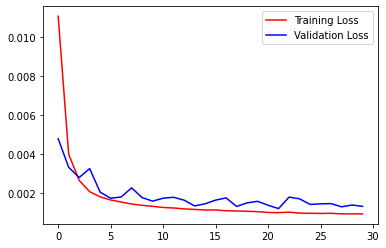

(7957, 6)
The Mean Squared Error is: 0.41897615724403864


In [25]:
## Saving the result file to the folder of the model
history = atten_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_wavenet.load_weights(filepath_attention)
preds = atten_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))

wk.save(working_dir / Path('Wavenet Results.xls'))